In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

plt.rcdefaults()

In [2]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

In [3]:
omega_index = 0 # while we debug, we confine our attention to just one value
onh2 = spectra.omegas_nu[omega_index]
onh2_str = spectra.omnu_strings[omega_index]

In [4]:
# It's a waste of time to consider all of the omegas and snapshots, so we're
# making heavy use of skips.
spec_sims = spectra.better_battery(spectra.omegas_nu, spectra.omnu_strings,
    skips_omega = [1, 2], skips_model=[8], skips_snapshot=[1, 2, 3],
    h_units=False)

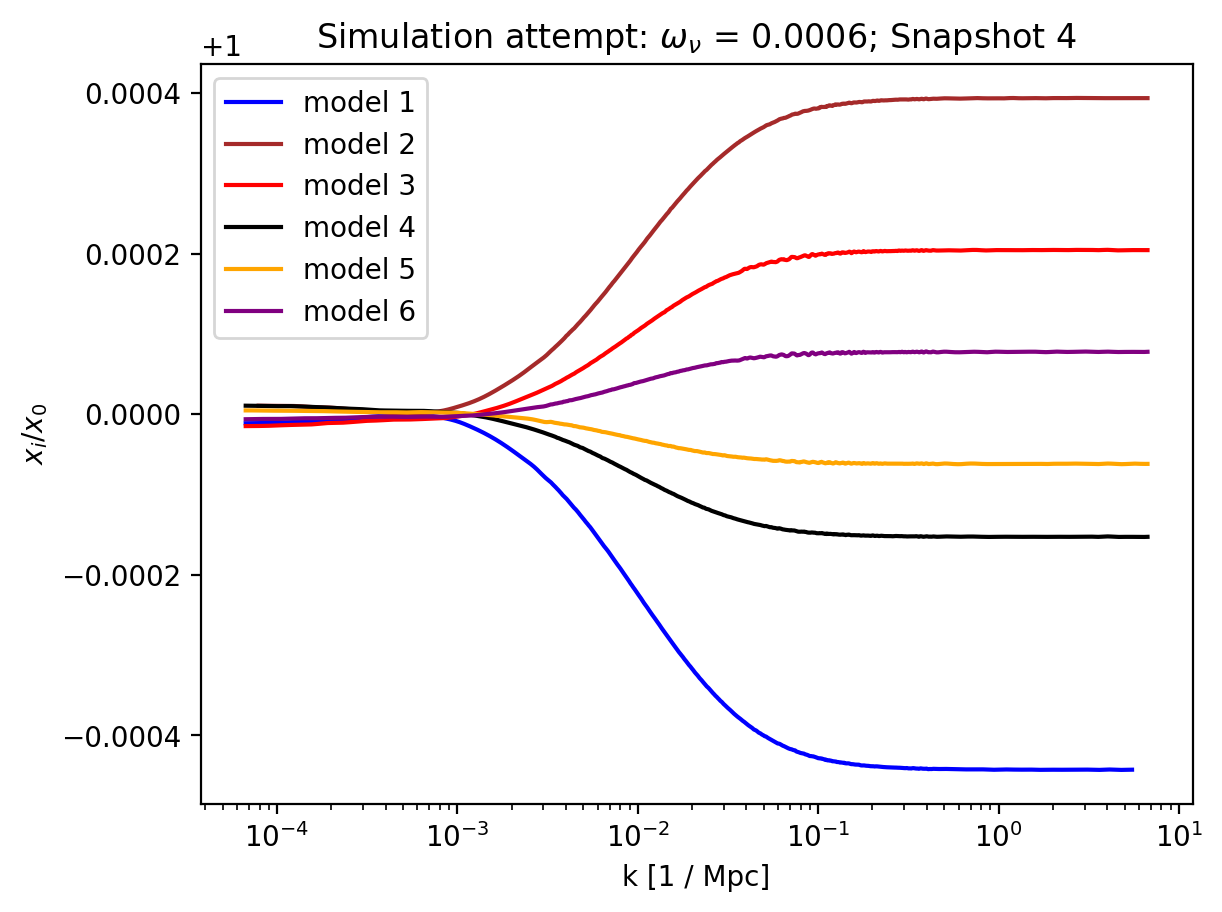

In [5]:
fig, axs = plt.subplots()
spectra.model_ratios_true(
    4, spec_sims[onh2_str], axs, massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title="Simulation attempt");

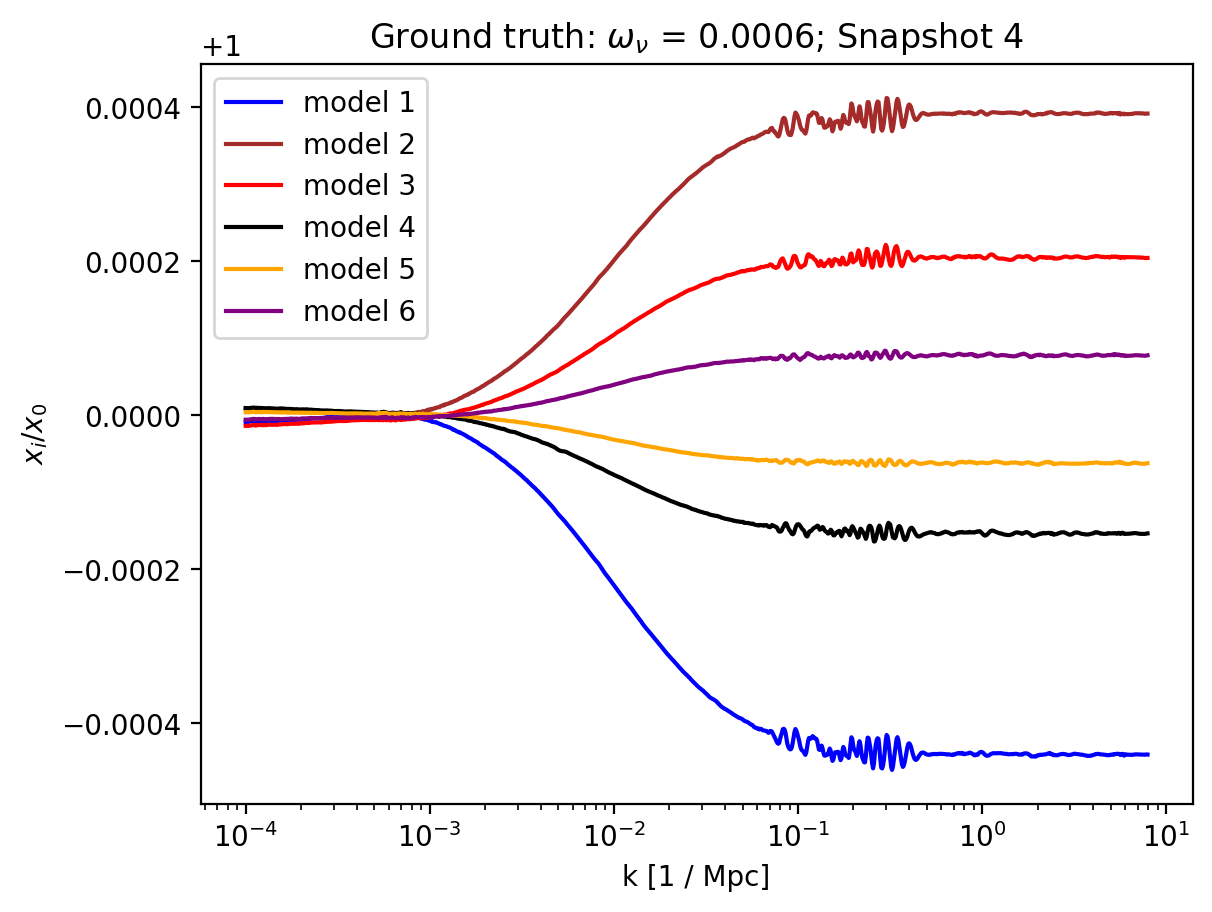

In [6]:
fig, axs = plt.subplots()
spectra.model_ratios_true(4, spectra.powernu[onh2_str], axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str);

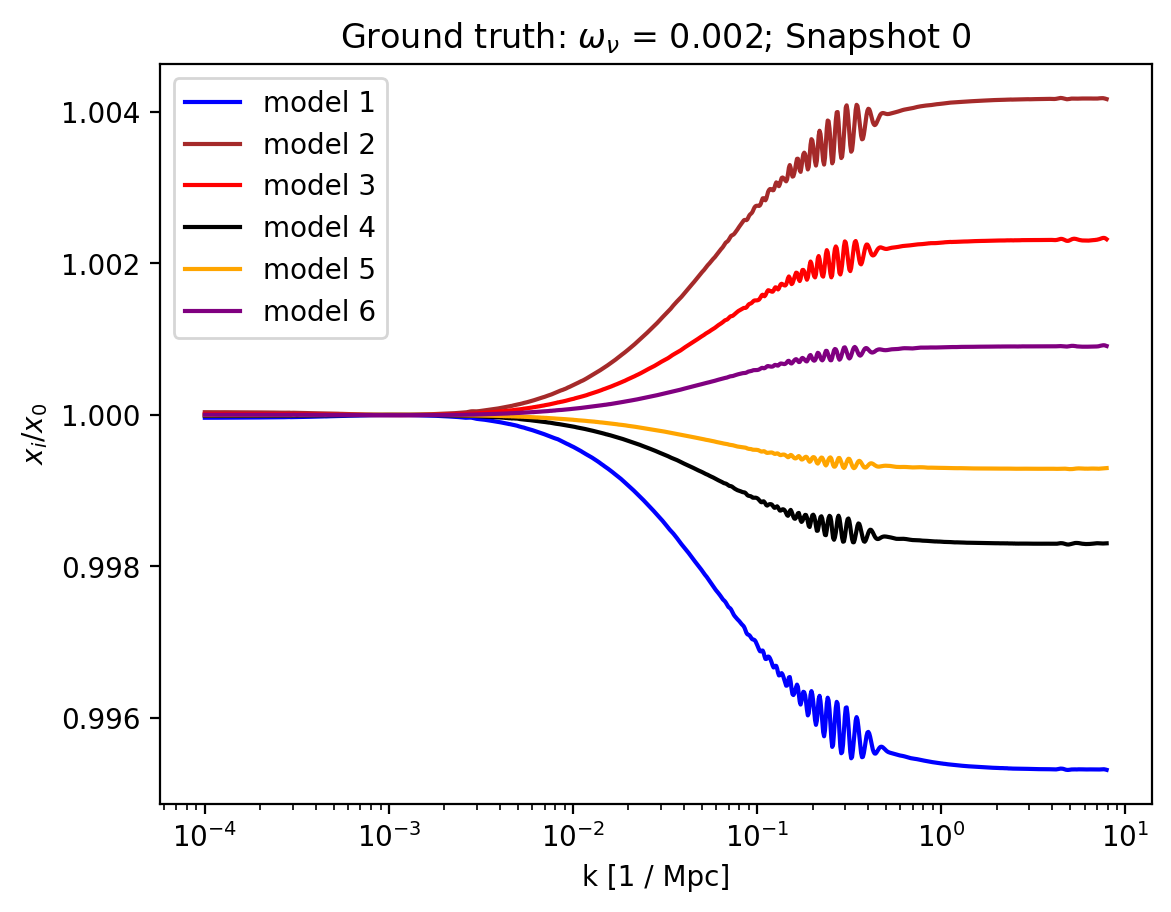

In [7]:
fig, axs = plt.subplots()
ks, rats = spectra.model_ratios_true(0, spectra.powernu2, axs,
    massive='x', skips=[7, 8], omnuh2_str="0.002");

In [8]:
# Be careful with the indexing here; rats[0] is the ratio of model 1 to model 0
true_asymptotes = np.array([rats[i][len(rats[i]) - 1] for i in range(len(rats))])
zc_asymptotes = true_asymptotes - 1

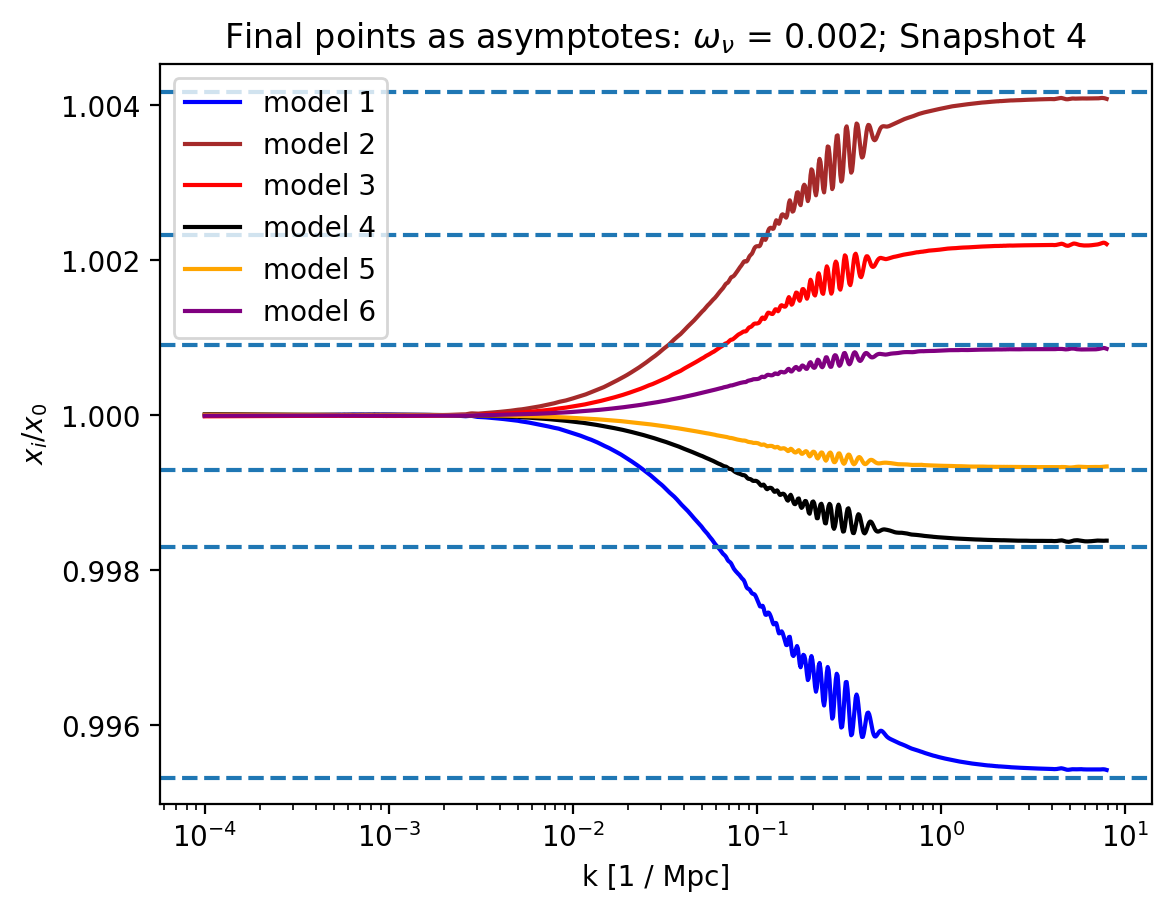

In [9]:
fig, axs = plt.subplots()
spectra.model_ratios_true(4, spectra.powernu2, axs,
    massive='x', skips=[7, 8], omnuh2_str="0.002",
    title="Final points as asymptotes")
for asymptote in true_asymptotes:
    axs.axhline(asymptote, linestyle='--')

0.9730217497565392
42.2107832023125
[0.00074024 0.00073818 0.00072627 0.00072163 0.00071925 0.00072154]


Text(0.5, 1.0, 'Fit results: $\\hat{y} = \\omega_\\nu \\, \\frac{A_s^i}{A_s^0}$')

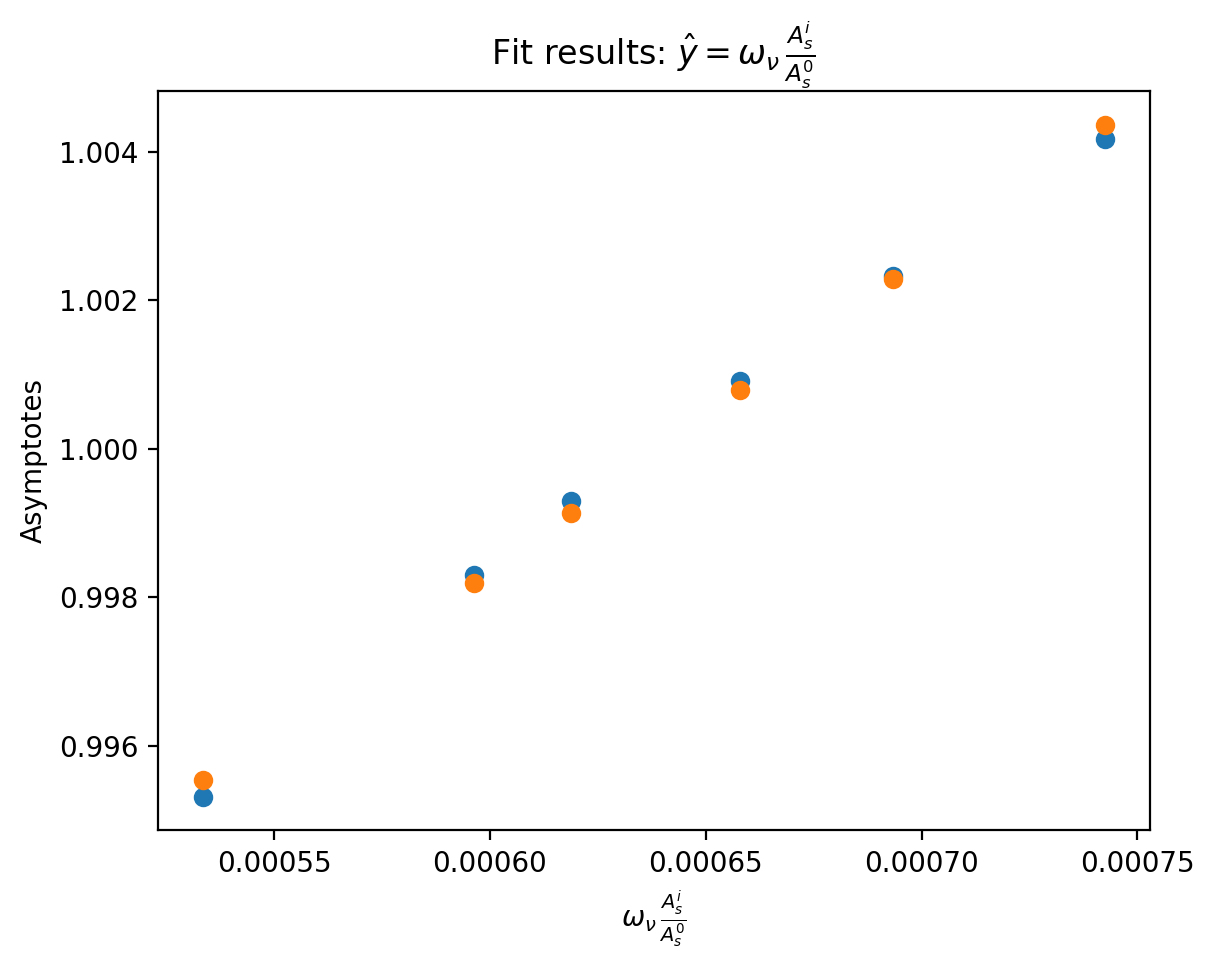

In [10]:
A_s = [spectra.cosm.loc[i]["A_s"] for i in range(7)]
from numpy.polynomial.polynomial import polyfit

x1 = onh2 * (A_s[1:] / A_s[0])
model_desc_1 = r"\omega_\nu \, \frac{A_s^i}{A_s^0}$"

plt.scatter(x1, true_asymptotes)

b1, m1 = polyfit(x1, true_asymptotes, 1)
plt.scatter(x1, m1 * x1 + b1)
print(b1)
print(m1)
print(np.square(true_asymptotes - m1 * x1 - 1))

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_1)
plt.title(r"Fit results: $\hat{y} = " + model_desc_1)

In [11]:
from sklearn.linear_model import LinearRegression
reg_b_centered_noyint = LinearRegression()
reg_b_centered_noyint.fit_intercept=False
X = x1.reshape(-1, 1)
fit_b_centered_noyint = reg_b_centered_noyint.fit(X, zc_asymptotes)
m_centered_noyint = fit_b_centered_noyint.coef_[0]
b_centered_noyint = fit_b_centered_noyint.intercept_
print(m_centered_noyint, b_centered_noyint)

0.5460792740346996 0.0


In [12]:
reg_b_centered_yint = LinearRegression()
reg_b_centered_yint.fit_intercept=True
X = x1.reshape(-1, 1)
fit_b_centered_yint = reg_b_centered_yint.fit(X, zc_asymptotes)
m_centered_yint = fit_b_centered_yint.coef_[0]
b_centered_yint = fit_b_centered_yint.intercept_
print(m_centered_yint, b_centered_yint)

42.210783202310736 -0.02697825024345948


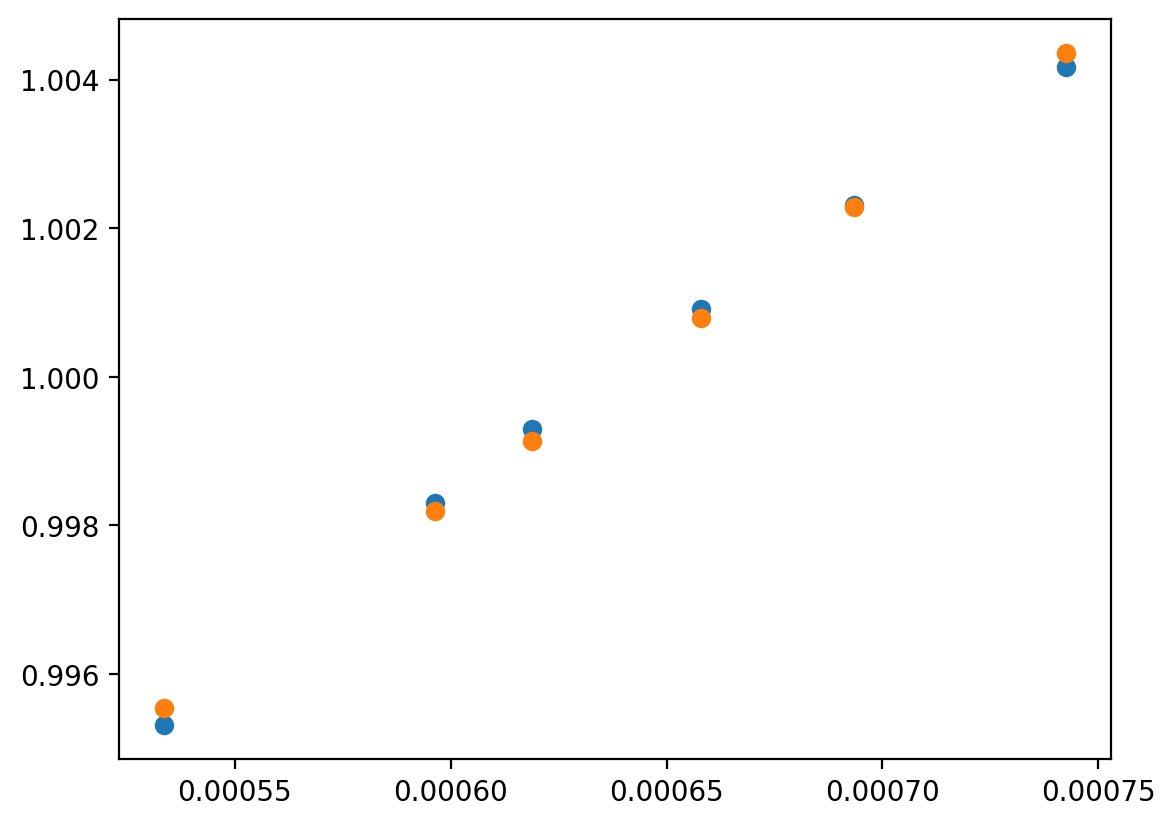

In [13]:
plt.scatter(x1, true_asymptotes)
plt.scatter(x1, m1 * onh2 * (A_s[1:] / A_s[0]) + b1)

In [14]:
C = m1

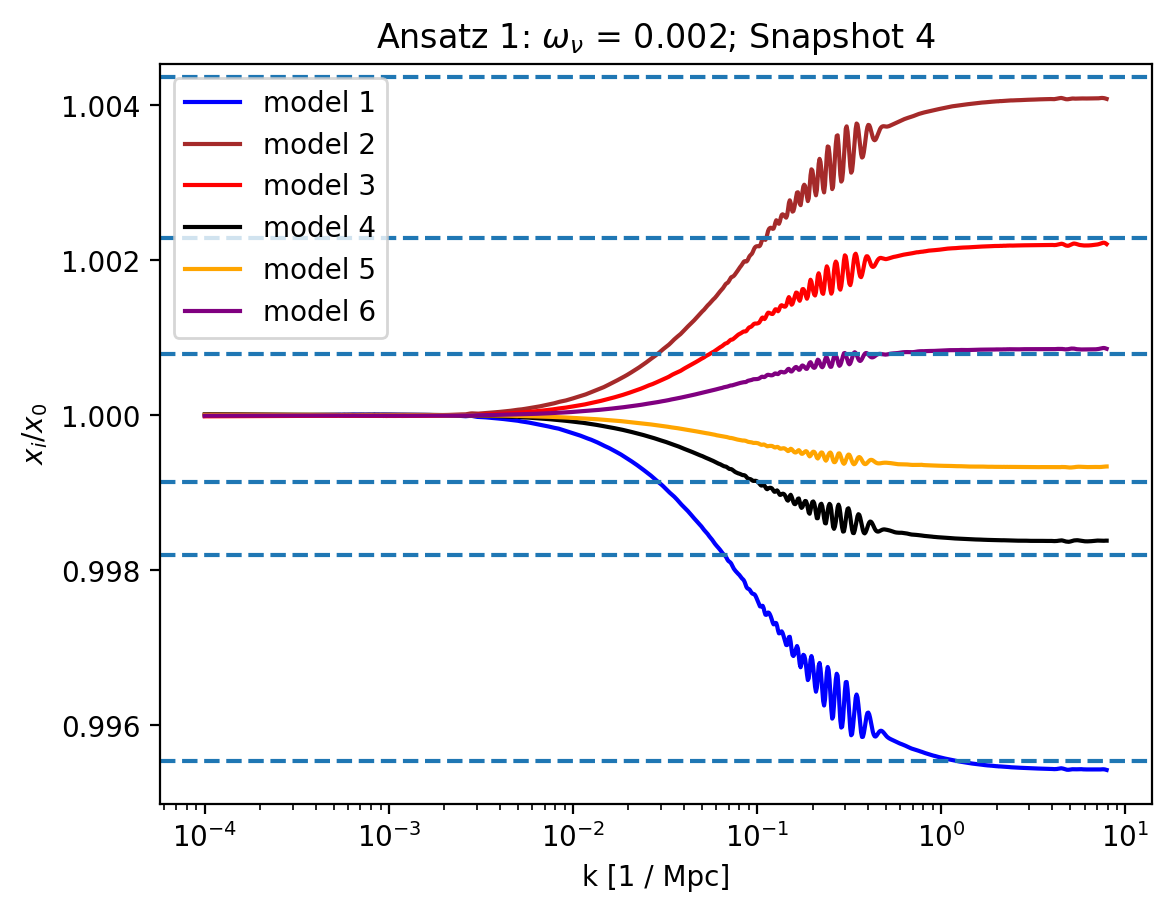

In [15]:
fig, axs = plt.subplots()
spectra.model_ratios_true(4, spectra.powernu2, axs,
    massive='x', skips=[7, 8], omnuh2_str="0.002",
    title="Ansatz 1");
for i in range(len(true_asymptotes)):
    axs.axhline(m1 * x1[i] + b1, linestyle='--')

0.9462561523286146
84.44108142425088
Reduced chi squared value for this fit: 6.104971761392795e-09


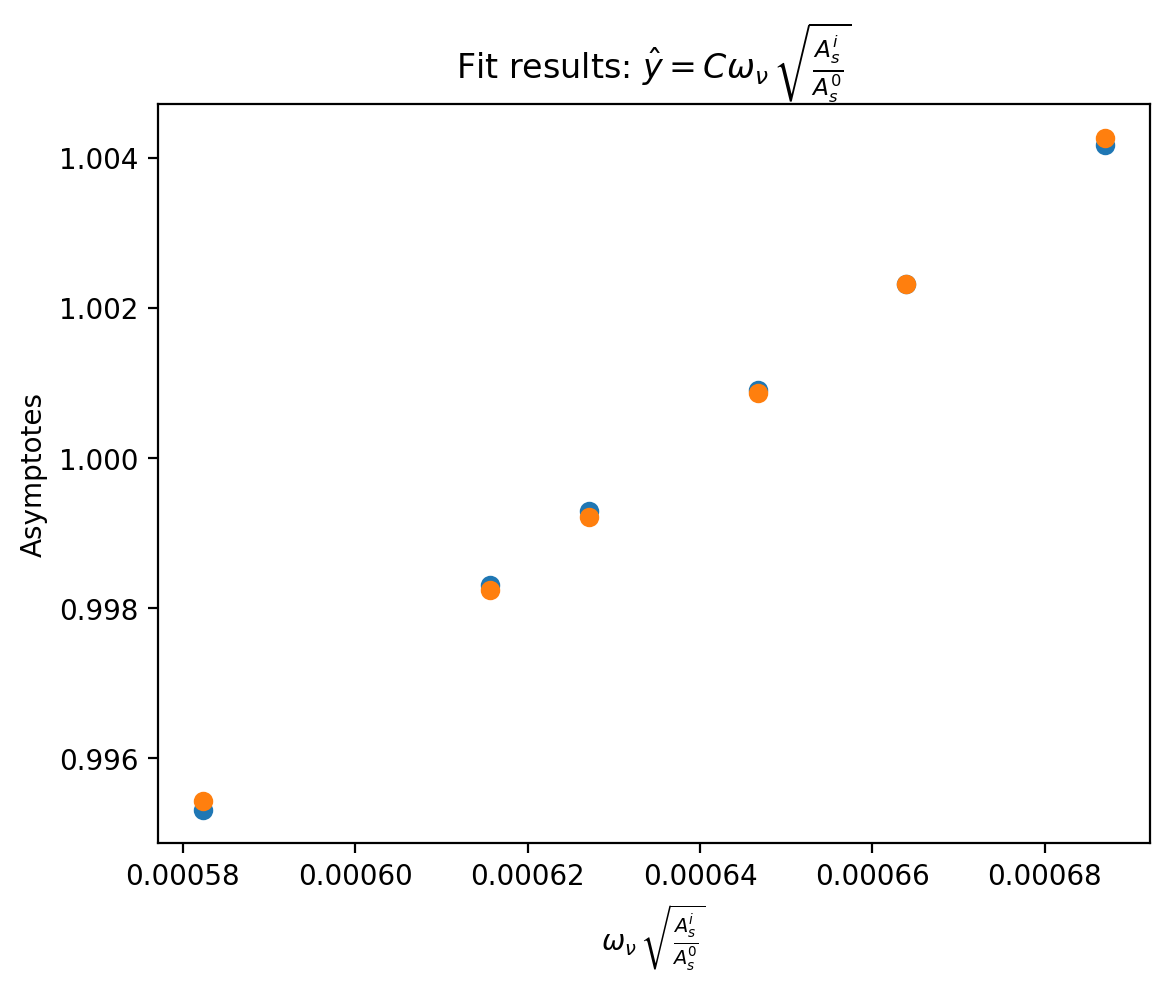

In [16]:
x2 = onh2 * np.sqrt(A_s[1:] / A_s[0])
model_desc_2 = r"\omega_\nu \, \sqrt{\frac{A_s^i}{A_s^0}}$"

plt.scatter(x2, true_asymptotes)

b2, m2 = polyfit(x2, true_asymptotes, 1)

pred2 = m2 * x2 + b2
plt.scatter(x2, pred2)

print(b2)
print(m2)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_2)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_2)

chis2 = (true_asymptotes - pred2) ** 2 / pred2
red_chisq2 = sum(chis) / len(x2)
print("Reduced chi squared value for this fit:", red_chisq2)

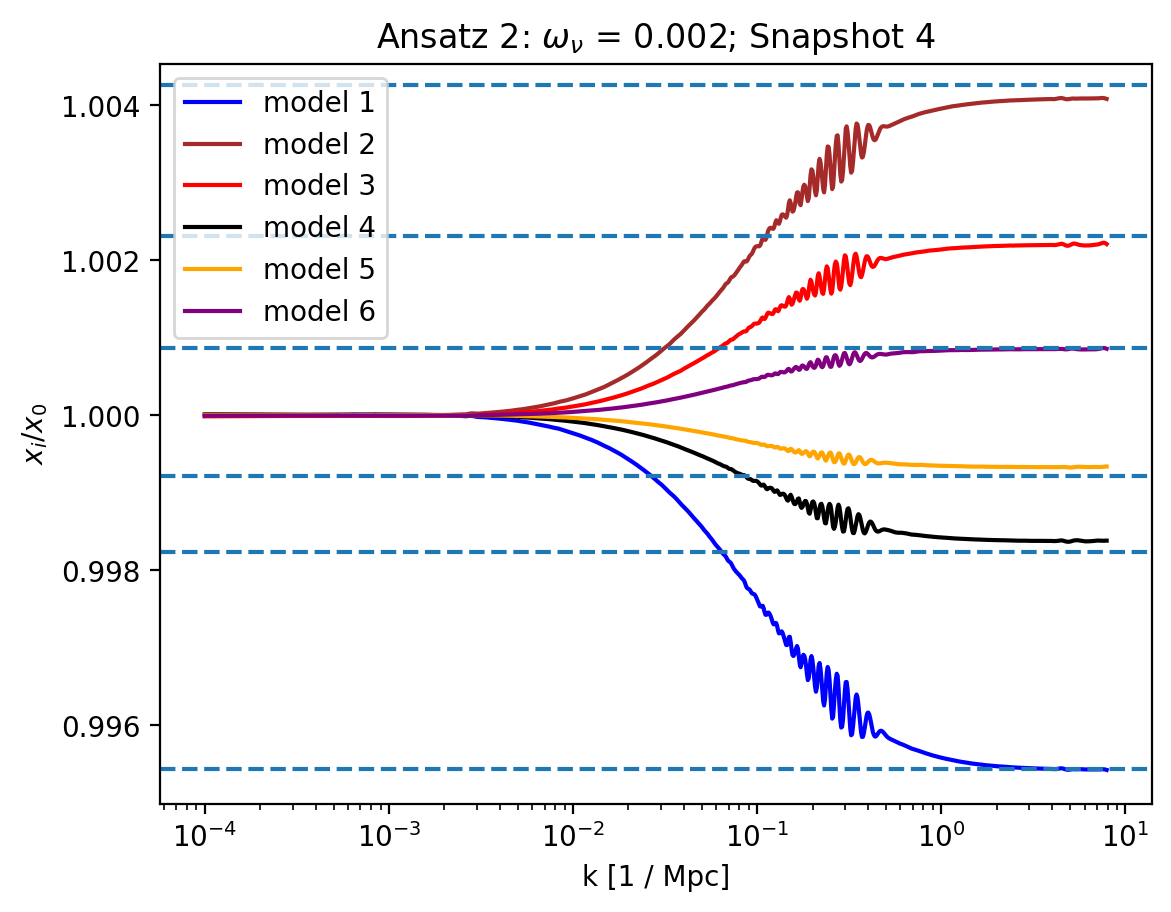

In [17]:
fig, axs = plt.subplots()
spectra.model_ratios_true(4, spectra.powernu2, axs,
    massive='x', skips=[7, 8], omnuh2_str="0.002",
    title="Ansatz 2");

for i in range(len(true_asymptotes)):
    axs.axhline(m2 * x2[i] + b2, \
        linestyle='--')

0.9194999209456325
126.5771406160271
Reduced chi squared value for this fit: 2.81711592221621e-09


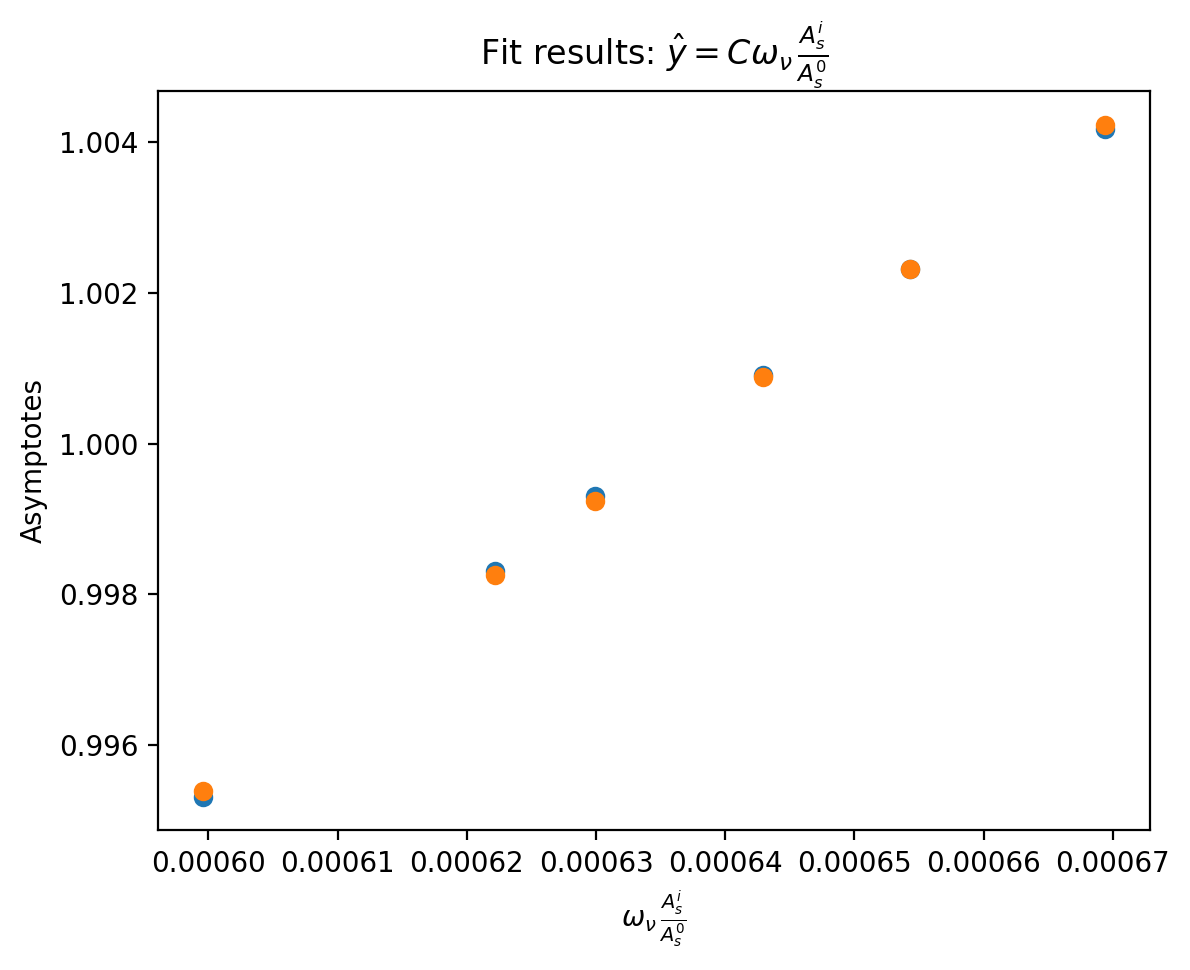

In [18]:
x3 = onh2 * np.power(A_s[1:] / A_s[0], 1/3)
model_desc_3 = r"\omega_\nu \, \frac{A_s^i}{A_s^0}$"

plt.scatter(x3, true_asymptotes)

b3, m3 = polyfit(x3, true_asymptotes, 1)

pred3 = m3 * x3 + b3
plt.scatter(x3, pred3)

print(b3)
print(m3)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_3)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_3)

chis3 = (true_asymptotes - pred3) ** 2 / pred3
red_chisq3 = sum(chis) / len(x3)
print("Reduced chi squared value for this fit:", red_chisq3)

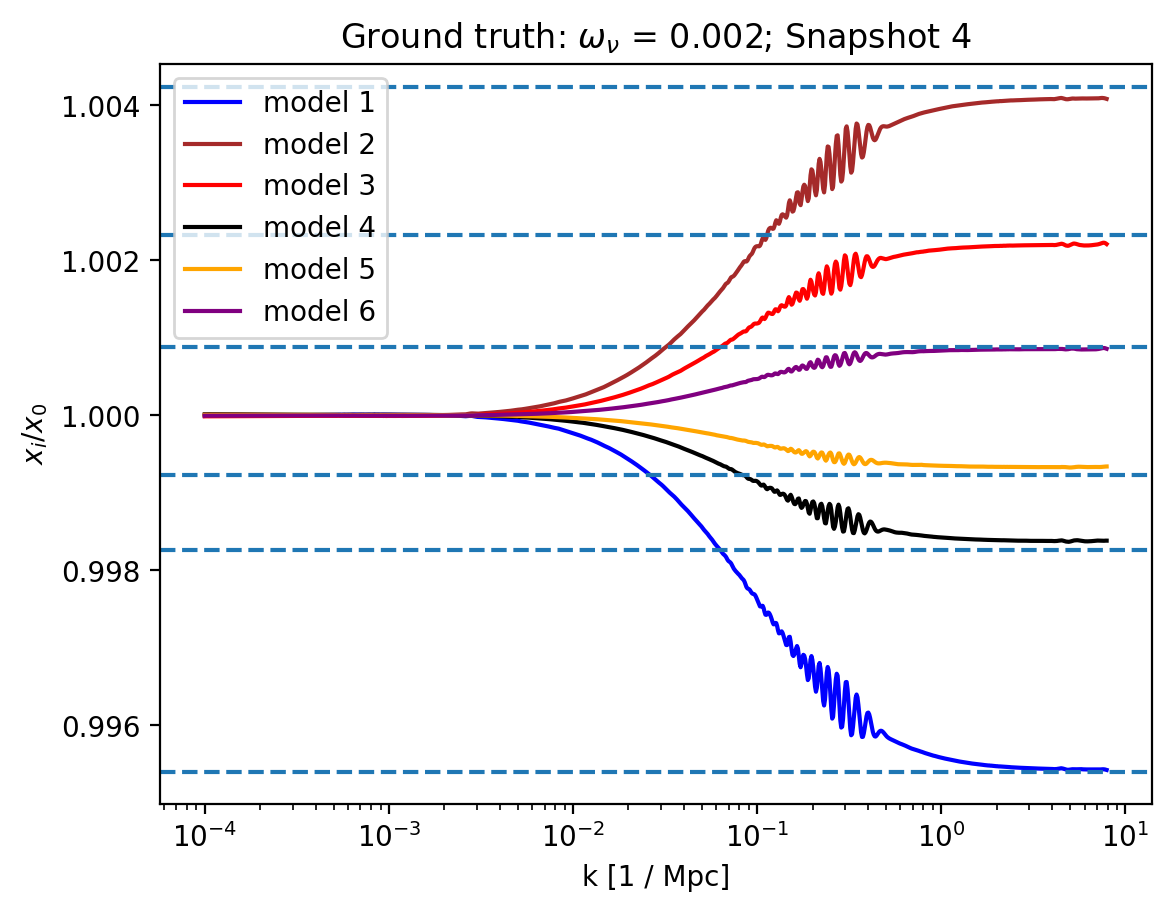

In [19]:
fig, axs = plt.subplots()
spectra.model_ratios_true(4, spectra.powernu2, axs,
    massive='x', skips=[7, 8], omnuh2_str="0.002")
for i in range(len(true_asymptotes)):
    axs.axhline(m3 * x3[i] + b3, linestyle='--')

0.8927459879630144
168.68958284130014
Reduced chi squared value for this fit: 2.81711592221621e-09


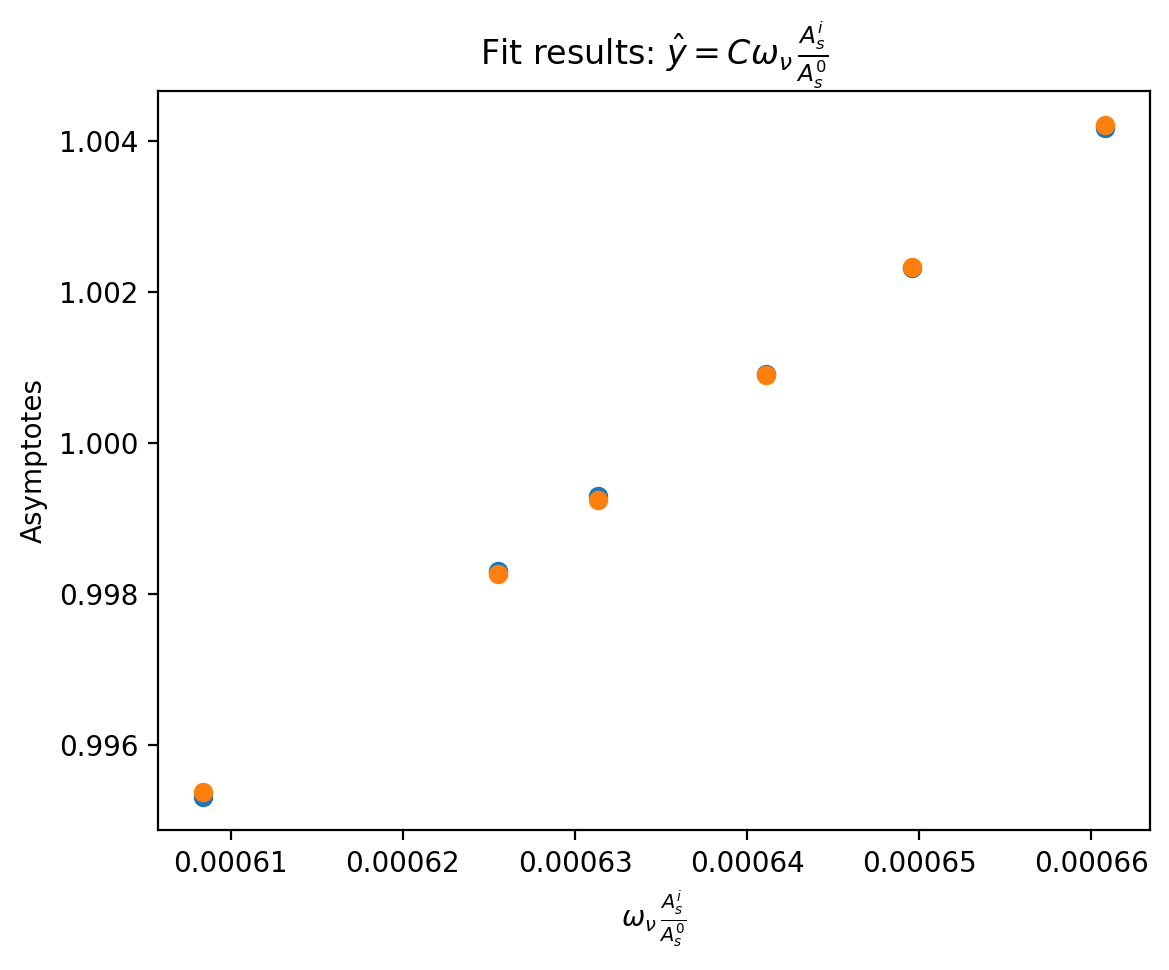

In [20]:
x4 = onh2 * np.power(A_s[1:] / A_s[0], 1/4)
model_desc_4 = r"\omega_\nu \, \frac{A_s^i}{A_s^0}$"

plt.scatter(x4, true_asymptotes)

b4, m4 = polyfit(x4, true_asymptotes, 1)

pred4 = m4 * x4 + b4
plt.scatter(x4, pred4)

print(b4)
print(m4)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_4)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_4)

chis4 = (true_asymptotes - pred4) ** 2 / pred4
red_chisq4 = sum(chis) / len(x4)
print("Reduced chi squared value for this fit:", red_chisq4)

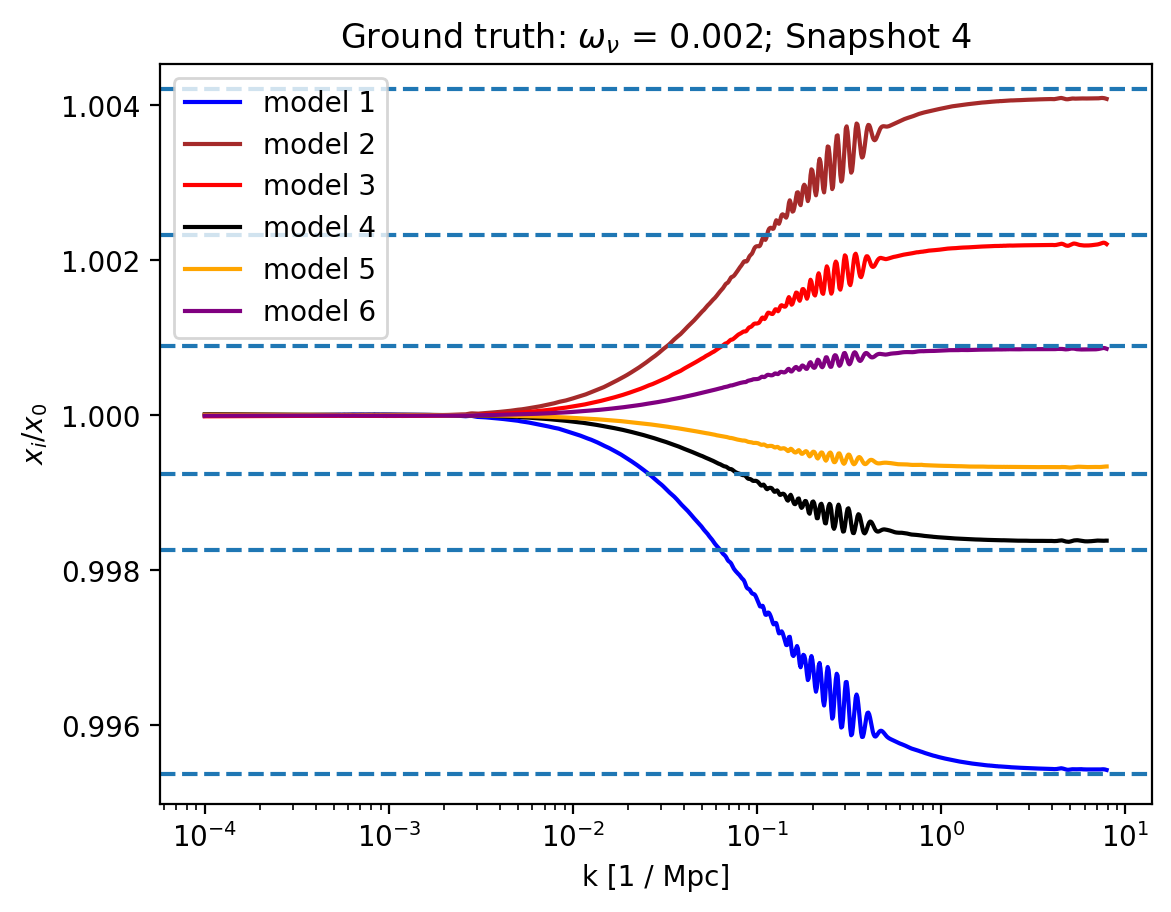

In [21]:
fig, axs = plt.subplots()
spectra.model_ratios_true(4, spectra.powernu2, axs,
    massive='x', skips=[7, 8], omnuh2_str="0.002")
for i in range(len(true_asymptotes)):
    axs.axhline(m4 * x4[i] + b4, linestyle='--')

In [25]:
x4

array([0.00060839, 0.00066078, 0.00064958, 0.00062553, 0.00063134,
       0.00064111])

0.8659929657141492
210.79258095686612
Reduced chi squared value for this fit: 2.81711592221621e-09


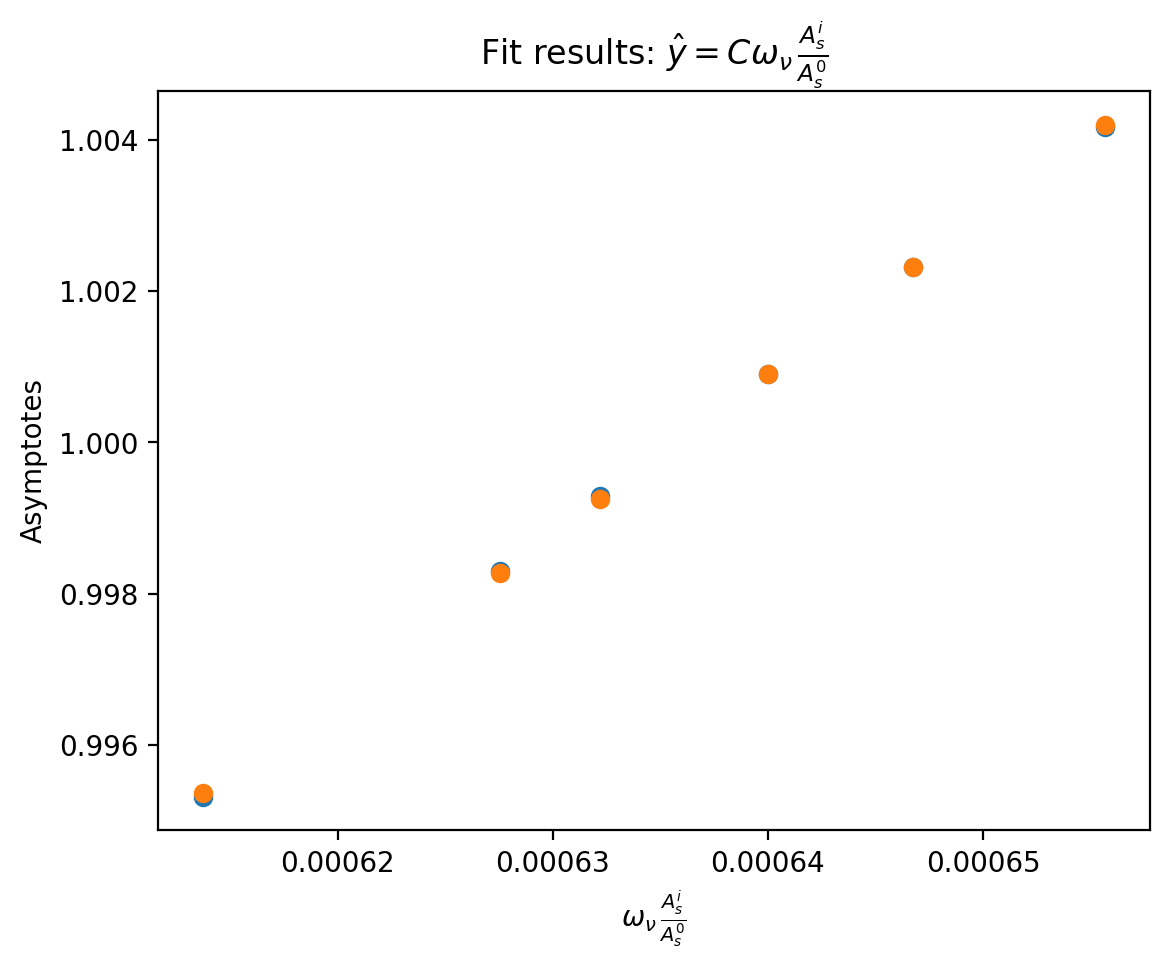

In [22]:
x5 = onh2 * np.power(A_s[1:] / A_s[0], 1/5)
model_desc_5 = r"\omega_\nu \, \frac{A_s^i}{A_s^0}$"

plt.scatter(x5, true_asymptotes)

b5, m5 = polyfit(x5, true_asymptotes, 1)

pred5 = m5 * x5 + b5
plt.scatter(x5, pred5)

print(b5)
print(m5)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_5)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_5)

chis5 = (true_asymptotes - pred5) ** 2 / pred5
red_chisq5 = sum(chis) / len(x5)
print("Reduced chi squared value for this fit:", red_chisq5)

In [24]:
x5

array([0.00061374, 0.00065566, 0.00064676, 0.00062753, 0.00063219,
       0.00064   ])

## 